# Regulome Explorer Notebook 1

Gene-gene correlations using PanCancer expression and copy number data.


## Authentication and Setup

### Authenticate with Google  (IMPORTANT)
Our first step is to authenticate with Google -- you will need to be a member of a Google Cloud Platform (GCP) project, with authorization to run BigQuery jobs in order to run this notebook.  If you don't have access to a GCP project, please contact the ISB-CGC team for help (www.isb-cgc.org)

In [1]:
# Running notebook locally...
!gcloud auth login


Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&prompt=select_account&response_type=code&client_id=32555940559.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&access_type=offline


[11806:11825:0508/110154.885591:ERROR:browser_process_sub_thread.cc(217)] Waited 6 ms for network service
Opening in existing browser session.
If you need to use ADC, see:
  gcloud auth application-default --help

You are now logged in as [dgibbs@systemsbiology.org].
Your current project is [isb-cgc-02-0001].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


In [ ]:
## IF YOU'RE IN GOOGLE COLAB ##

from google.colab import auth
try:
  auth.authenticate_user()
  print('You have been successfully authenticated!')
except:
  print('You have not been authenticated.')

### Initialize connection to BigQuery  (IMPORTANT)
Once you're authenticated, we'll begin getting set up to pull data out of BigQuery.  

The first step is to initialize the BigQuery client.  This requires specifying a Google Cloud Platform (GCP) **project id** in which you have the necessary privileges (also referred to as "roles") to execute queries and access the data used by this notebook.

Below, we use a GCP project called ``isb-cgc-bq``.  If you have your own GCP project that you would like to use instead,  please **edit** the line below that sets the ``project_id`` variable *before* running the next cell.

In [3]:
from google.cloud import bigquery

try:
  project_id = 'isb-cgc-02-0001'
  bqclient = bigquery.Client(project=project_id)
  print('BigQuery client successfully initialized')
except:
  print('Failure to initialize BigQuery client')

/home/davidgibbs/.local/lib/python3.6/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


BigQuery client successfully initialized


### Software Configuration

Unless any part of this section fails to run, you only need to look at this in detail if you are interested in understanding how this notebook works or in modifying it for your own purposes.  

Note that running this section alone will take about **5 minutes** due to the sizes of some of the libraries being imported, as well as the number of dependent libraries.  

Of course, once this section has been run, you will be able to run, modify, and re-run any of the later sections of this notebook without having to come back and rerun this section (as long as you have not lost your connection to the Jupyter server).

#### Import Python libraries

Import NumPy, Pandas, and seaborn

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns

#### Python convenience functions

We define two convenience functions here:

- **`runQuery`**: a relatively generic BigQuery query-execution wrapper function which can be used to run a query in "dry-run"  mode or not:  the call to the `query()` function itself is inside a `try/except` block and if it fails we return `None`;  otherwise a "dry" will return an empty dataframe, and a "live" run will return the query results as a dataframe

- **`checkQueryResults`**: a generic function that makes sure that what was returned is a dataframe, and checks how many rows are in the returned dataframe

In [5]:
def runQuery ( client, qString, dryRun=False ):
  
  print ( "\n in runQuery ... " )
  if ( dryRun ):
    print ( "    dry-run only " )
    
  ## set up QueryJobConfig object
  job_config = bigquery.QueryJobConfig()
  job_config.dry_run = dryRun
  job_config.use_query_cache = True
  job_config.use_legacy_sql = False
  
  ## run the query
  try:
    query_job = client.query ( qString, job_config=job_config )
    ## print ( "    query job state: ", query_job.state )
  except:
    print ( "  FATAL ERROR: query execution failed " )
    return ( None )
  
  ## return results as a dataframe (or an empty dataframe for a dry-run) 
  if ( not dryRun ):
    try:
      df = query_job.to_dataframe()
      if ( query_job.total_bytes_processed==0 ):
        print ( "    the results for this query were previously cached " )
      else:
        print ( "    this query processed {} bytes ".format(query_job.total_bytes_processed) )
      if ( len(df) < 1 ):
        print ( "  WARNING: this query returned NO results ")
      return ( df )
    except:
      print ( "  FATAL ERROR: query execution failed " )
      return ( None )
    
  else:
    print ( "    if not cached, this query will process {} bytes ".format(query_job.total_bytes_processed) )
    ## return an empty dataframe
    return ( pd.DataFrame() )
 


def checkQueryResults ( qr ):
  print ( "\n in checkQueryResults ... " )
  if ( not isinstance(qr, pd.DataFrame) ):
    print ( " query execution failed! " )
    return ( False )
  else:
    if ( len(qr) > 0 ): 
      print ( " # of rows in query results: {} ".format(len(qr)) )
      print ( "\n", qr.head() )
    else:
      print ( " query returned NO results ?!? " )  
    return ( True )

### SQL Building Functions


In [32]:
def build_cohort ( study ):
  qString = """
      WITH
        --
        -- we start with the clinical table
        --
        cohort AS (
        SELECT
          acronym as Study,
          bcr_patient_barcode as ParticipantBarcode
        FROM
          `isb-cgc-01-0008.Filtered.clinical_PANCAN_patient_with_followup_filtered` 
         WHERE
          acronym = '__study__'
          )
          """.replace('__study__',study)
  return(qString)
  

In [33]:
def select_genes ( dtype, n ):
  if dtype == 'expr':
    qString = """
      selected_genes AS (
      SELECT
        Symbol,
        STDDEV(normalized_count) AS sigmaExp
      FROM
        `isb-cgc-01-0008.Filtered.EBpp_AdjustPANCAN_RNASeqV2_filtered`
      WHERE
        Symbol IS NOT NULL
        AND ParticipantBarcode IN (
          SELECT
            ParticipantBarcode
          FROM
            cohort)
      GROUP BY
        1
      ORDER BY
        sigmaExp DESC
      LIMIT
        __n__ )
      """.replace('__n__', str(n))
    
  elif dtype == 'cnv':
    qString = """
      selected_genes AS (
      SELECT
        Gene_Symbols as Symbol,
        STDDEV(GISTIC_Calls) AS sigmaExp
      FROM
        `isb-cgc-01-0008.Filtered.all_CNVR_data_by_gene_filtered`
      WHERE
        Symbol IS NOT NULL
        AND ParticipantBarcode IN (
          SELECT
            ParticipantBarcode
          FROM
            cohort)
      GROUP BY
        1
      ORDER BY
        sigmaExp DESC
      LIMIT
        __n__ )
      """.replace('__n__', str(n))
  else:
    # 
    # Could be some other gene selection function here ##
    #
    qString = ''
  return(qString)

In [34]:
def get_expr_data(i):
  qString = """
      expr_data__i__ AS (
      SELECT
        Symbol,
        ParticipantBarcode,
        SampleBarcode,
        normalized_count as expr,
        DENSE_RANK() OVER (PARTITION BY SampleBarcode ORDER BY normalized_count ASC) AS rankExpr
      FROM
        `isb-cgc-01-0008.Filtered.EBpp_AdjustPANCAN_RNASeqV2_filtered`
      WHERE
        Symbol IS NOT NULL AND
        Symbol IN (
          SELECT
            Symbol
          FROM
            selected_genes)
        AND ParticipantBarcode IN (
          SELECT
            ParticipantBarcode
          FROM
            cohort) 
      )
  """.replace('__i__', '_'+str(i))
  return(qString)


In [47]:
  def join_data(i,j):
    qString = """
      j_data AS (
      SELECT
       expr_data_1.Symbol as expr_data_1_Symbol,
       expr_data_1.SampleBarcode,
       expr_data_1.rankExpr as expr_data_1_rankExpr,
       expr_data_1.expr,
       expr_data_2.Symbol as expr_data_2_Symbol,
       expr_data_2.SampleBarcode,
       expr_data_2.rankExpr as expr_data_2_rankExpr,
       expr_data_2.expr
      FROM
        expr_data__i__ JOIN expr_data__j__ 
      ON
        expr_data__i__.SampleBarcode = expr_data__j__.SampleBarcode
        AND expr_data__i__.Symbol > expr_data__j__.Symbol 
      )
    """.replace('__i__', '_'+str(i)).replace('__j__', '_'+str(j))
    return(qString)

In [36]:
def comp_corr(i,j):
  qString = """
  corr_table AS (
  SELECT
    expr_data__i___Symbol,
    expr_data__j___Symbol,
    CORR(expr_data__i___rankExpr,expr_data__j___rankExpr) AS corr
  FROM
    j_data
  GROUP BY
    1,2
  ORDER BY
    corr DESC
    )
  """.replace('__i__', '_'+str(i)).replace('__j__', '_'+str(j))
  return(qString)


In [37]:
def final( last_table ):
  qString = """
  SELECT * FROM __last_table__
  """.replace('__last_table__', last_table)
  return(qString)


In [38]:
def build_query( study, dtype, size ): 
  i = '1'
  j = '2'
  sql = (
    build_cohort( study ) + ',\n' +
    select_genes ( dtype, size ) + ',' +
    get_expr_data(i) + ',\n' +
    get_expr_data(j) + ',\n' +  #### change here
    join_data(i,j) + ',\n' +
    comp_corr(i,j) + '\n' +
    final( 'corr_table' )
  )
  return(sql)

##  Select variables to analyze



Choose a TCGA study, number of genes, and the data source to use in ranking genes.

In [48]:
# select a tumor type

studyList = [ 'ACC', 'BLCA', 'BRCA', 'CESC', 'CHOL', 'COAD', 'DLBC', 'ESCA', 
                'GBM', 'HNSC', 'KICH', 'KIRC', 'KIRP', 'LAML', 'LGG', 'LIHC', 
                'LUAD', 'LUSC', 'MESO', 'OV', 'PAAD', 'PCPG', 'PRAD', 'READ', 
                'SARC', 'SKCM', 'STAD', 'TGCT', 'THCA', 'THYM', 'UCEC', 'UCS', 'UVM' ]

study = studyList[6]

# choosing which genes to look at
n  = 100     # the n most variable genes

# building the query string
sql = build_query (study, 'expr', n)

# print(sql)

In [49]:
# calling Google! #

res0 = runQuery ( bqclient, sql, dryRun=False )



 in runQuery ... 
    this query processed 10416423703 bytes 


## Results


In [51]:
res0.shape

(4950, 3)

In [55]:
res0['index'] = range(0,4950)

In [56]:
res0 [0:10]

,expr_data_1_Symbol,expr_data_2_Symbol,corr,index
0,PGA4,LIPF,0.999086,0
1,PGC,PGA4,0.998607,1
2,PGC,LIPF,0.998592,2
3,PGA3,LIPF,0.998415,3
4,PGA4,PGA3,0.998272,4
5,PGC,PGA3,0.997350,5
6,C1QB,C1QA,0.958305,6
7,COL3A1,COL1A1,0.942048,7
8,COL1A2,COL1A1,0.933614,8
9,COL3A1,COL1A2,0.900852,9


/home/davidgibbs/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


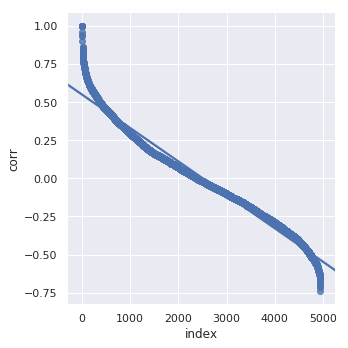

In [57]:
import seaborn as sns
sns.set(style = 'darkgrid')

sns.lmplot(x='index', y='corr', data=res0)

---